# Model embedding analysis

This python jupyter notebook plots the model embeddings to see how the model captures the features of  different tasks.

## Set up analysis

### Import python modules

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sys
import os
sys.path.insert(0,os.path.dirname(os.getcwd()))
from src.dataset import DMS_data
from sklearn.model_selection import KFold

/home/chenn0a/.conda/envs/python3-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read in the data

In [2]:
## Load the true labels of the data
kf=KFold(n_splits=5,random_state=3,shuffle=True)
data=DMS_data(data_path="../data/GMM_covid_info_seq.csv",msa=False)
class_label = data.class_label
data=data.get_data()
for train_index,test_index in kf.split(data):
    class_label=class_label[train_index]
    break
class_label=np.argmax(class_label,axis=-1)

In [3]:
## Load the embeddings
embeddings=np.load('../result/model_embedding.npy')
embeddings=np.reshape(embeddings,(15305,9*2580)) ## sample_number, n_tasks*embedding_dim

## Principle component analysis

In [4]:
pca=PCA(n_components=10)
pca_embeddings=pca.fit_transform(embeddings)

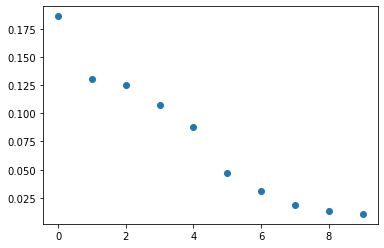

In [5]:
#PCA components plot
plt.scatter(list(range(0,10)),pca.explained_variance_ratio_)

In [6]:
label_for_ACE2=np.vectorize({0:"non-binder",1:"binder"}.get)(class_label[:,0])
label_for_escape=np.vectorize({0:"non-escape",1:"escape"}.get)(class_label)
pca_df=pd.DataFrame({"PC1":pca_embeddings[:,0],"PC2":pca_embeddings[:,1],"ACE2_binding":label_for_ACE2,"2096":label_for_escape[:,1],"2832":label_for_escape[:,2],"2094":label_for_escape[:,3],"2050":label_for_escape[:,4],"2677":label_for_escape[:,5],"2479":label_for_escape[:,6],"2165":label_for_escape[:,7],"2499":label_for_escape[:,8]})

In [7]:
def get_class_label(l1,l2):
    if l1=="escape" or l2=="escape":
        return "escape"
    else:
        return "non-escape"

In [8]:
pca_df["class1"]=pca_df.apply(lambda x:get_class_label(x["2165"],x["2832"]),axis=1)
pca_df["class2"]=pca_df.apply(lambda x:get_class_label(x["2479"],x["2050"]),axis=1)
pca_df["class3"]=pca_df.apply(lambda x:get_class_label(x["2499"],x["2096"]),axis=1)
pca_df["class4"]=pca_df.apply(lambda x:get_class_label(x["2094"],x["2677"]),axis=1)

In [9]:
pca_df.head()

,PC1,PC2,ACE2_binding,2096,2832,2094,2050,2677,2479,2165,2499,class1,class2,class3,class4
0,-30.451467,-2.459431,non-binder,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape
1,-6.931268,-40.080631,non-binder,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape
2,-11.680498,-1.191091,non-binder,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape
3,-18.907607,-23.414329,non-binder,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape,non-escape
4,-7.261784,-19.282046,non-binder,non-escape,non-escape,non-escape,escape,non-escape,non-escape,non-escape,non-escape,non-escape,escape,non-escape,non-escape


In [10]:
LP = 0
UP = 100

def window_smooth(x, qfunc, lp=LP, up=UP):
    bins = np.linspace(np.percentile(x,LP), np.percentile(x,UP), 100)
    
    qacc = []
    for i in range(len(bins)-1):
        mask = np.logical_and(x > bins[i], x <= bins[i+1])
        qacc.append(np.mean(qfunc[mask]))
        
    qacc = np.array(qacc)
    qacc_x = (bins[1:] + bins[:-1])/2
    
    return qacc_x, qacc

In [11]:
buffer=0.3
s=pca_embeddings[:,:2]
std_x = np.std(s[:,0])
std_y = np.std(s[:,1])
xp = np.percentile(s[:,0], [LP, UP])
xlim = [xp[0]-buffer*std_x, xp[1]+buffer*std_x]
    
yp = np.percentile(s[:,1], [LP, UP])
ylim = [yp[0]-buffer*std_y, yp[1]+buffer*std_y]

In [12]:
plt.rcParams.update({'font.size': 13})

(-62.49771565999036, 73.3432830797718)

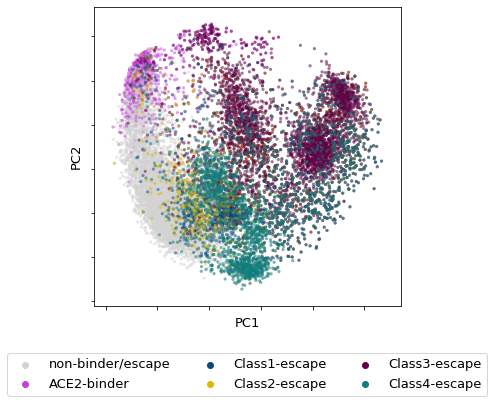

In [33]:
plt.figure(figsize=(5.5,5.5))
ax=sns.scatterplot(x="PC1",y="PC2",data=pca_df,hue="ACE2_binding",palette=["#D3D3D3","#c640d7ff"],s=10,edgecolor="none",alpha=0.5)
sns.scatterplot(ax=ax,x="PC1",y="PC2",data=pca_df[pca_df["class1"]=="escape"],hue="class1",s=10,edgecolor="none",palette=["#044b7f"],alpha=0.5)
sns.scatterplot(ax=ax,x="PC1",y="PC2",data=pca_df[pca_df["class2"]=="escape"],hue="class2",s=10,edgecolor="none",palette=["#e3b505"],alpha=0.5)
sns.scatterplot(ax=ax,x="PC1",y="PC2",data=pca_df[pca_df["class3"]=="escape"],hue="class3",s=10,edgecolor="none",palette=["#610345"],alpha=0.5)
sns.scatterplot(ax=ax,x="PC1",y="PC2",data=pca_df[pca_df["class4"]=="escape"],hue="class4",s=10,edgecolor="none",palette=["#107e7d"],alpha=0.5)
handles, labels  =  ax.get_legend_handles_labels()
plt.legend(handles,["non-binder/escape","ACE2-binder","Class1-escape","Class2-escape","Class3-escape","Class4-escape"],bbox_to_anchor=(0.5,-0.3), loc='lower center', borderaxespad=0,ncol=3)
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().set_xlim(xlim)
plt.gca().set_ylim(ylim)
#plt.savefig('figures/classes_combined_embedding.png',dpi=500,bbox_inches = 'tight')


/tmp/ipykernel_185015/1883328603.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(qacc_x, qacc, '-k', linewidth=4,color=c)
/tmp/ipykernel_185015/1883328603.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(qacc_x, qacc, '-k', linewidth=4,color=c)
/tmp/ipykernel_185015/1883328603.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(qacc_x, qacc, '-k', linewidth=4,color=c)
/tmp/ipykernel_185015/1883328603.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(qacc_x, qacc, '-k', linewidth=4,color=c)
/tmp/ipy

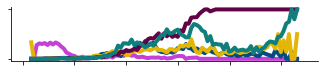

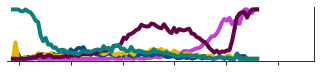

In [15]:
plt.figure(figsize=(5.5,1))
for task in ["ACE2_binding","class1","class2","class3","class4"]:
    c={"class1":"#044b7f","class2":"#e3b505","class3":"#610345","class4":"#107e7d","ACE2_binding":"#c640d7ff"}[task]
    if task=="ACE2_binding":
        qacc_x, qacc = window_smooth(pca_embeddings[:,0], pca_df[task].map({"binder":1,"non-binder":0}), lp=LP, up=UP)
    else:
        qacc_x, qacc = window_smooth(pca_embeddings[:,0], pca_df[task].map({"escape":1,"non-escape":0}), lp=LP, up=UP)
    plt.plot(qacc_x, qacc, '-k', linewidth=4,color=c)
plt.gca().set_xlim(xlim)
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
#plt.savefig('../figures/combined_embedding_pc1.png',dpi=500,bbox_inches = 'tight')
plt.figure(figsize=(5.5,1))
for task in ["ACE2_binding","class1","class2","class3","class4"]:
    c={"class1":"#044b7f","class2":"#e3b505","class3":"#610345","class4":"#107e7d","ACE2_binding":"#c640d7ff"}[task]
    if task=="ACE2_binding":
        qacc_x, qacc = window_smooth(pca_embeddings[:,1], pca_df[task].map({"binder":1,"non-binder":0}), lp=LP, up=UP)
    else:
        qacc_x, qacc = window_smooth(pca_embeddings[:,1], pca_df[task].map({"escape":1,"non-escape":0}), lp=LP, up=UP)
    plt.plot(qacc_x, qacc, '-k', linewidth=4,color=c)
plt.gca().set_xlim(xlim)
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
# plt.yticks([])
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('figures/combined_embedding_pc2.png',dpi=500,bbox_inches = 'tight')

    